# Plotting Helper

In [1]:
def plot_coverage_comparison(
    df_uncal,
    df_cal,
    *,
    alpha_col: str = "alpha",
    cov_col: str = "coverage",
    labels=("Before CP", "After CP"),
    title: str = "Coverage Comparison",
    ax=None,
    # --- NEW style controls to align with field plots ---
    figsize=(6, 5),          # match plot_uq_field default
    n_ticks: int = 9,        # number of major ticks on each axis (incl. endpoints)
    font_size: int = 12,     # label/title font
    tick_size: int = 10,     # tick label size
    grid_alpha: float = 0.2, # grid transparency
    box_aspect: float = 1.0, # make axes square like your field panels
    # --- extras to match your latest styling ---
    lw: float = 5.0,         # line width for both curves
    ms1: float = 13.0,       # marker size for uncal curve
    ms2: float = 20.0,       # marker size for cal curve
    pad: float = 0.03,       # extra margin so endpoints are visible
    legend_fontsize: int = 14
):
    """
    Plot empirical vs expected coverage for two models, styled to align with the 2D field plots.
    """
    import numpy as np
    import matplotlib.pyplot as plt
    from matplotlib.ticker import LinearLocator, FormatStrFormatter

    def _prepare(df):
        exp = 1.0 - df[alpha_col].to_numpy()
        emp = df[cov_col].to_numpy()
        # include endpoints for cleaner lines
        exp = np.concatenate(([0.0], exp, [1.0]))
        emp = np.concatenate(([0.0], emp, [1.0]))
        idx = np.argsort(exp)
        return exp[idx], emp[idx]

    exp1, emp1 = _prepare(df_uncal)
    exp2, emp2 = _prepare(df_cal)

    if ax is None:
        fig, ax = plt.subplots(figsize=figsize)
    else:
        fig = ax.figure

    # Curves + ideal diagonal
    ax.plot(exp1, emp1, marker='o', linestyle='-', color="#b13c32",
            markerfacecolor="#ed8076", ms=ms1, lw=lw, label=f'{labels[0]}',
            clip_on=False)
    ax.plot(exp2, emp2, marker='*', linestyle='-', color="#3245b1",
            markerfacecolor="#6988ef", ms=ms2, lw=lw, label=f'{labels[1]}',
            clip_on=False)
    ax.plot([0, 1], [0, 1], '--', color='gray', lw=max(2, lw*0.4), label='Ideal (y=x)',
            clip_on=False)

    # Limits, ticks, grid to match the field panels
    # Use autoscale + margins so endpoints aren't cramped
    ax.autoscale(enable=True, tight=False)
    ax.margins(x=pad, y=pad)

    ax.xaxis.set_major_locator(LinearLocator(n_ticks))
    ax.yaxis.set_major_locator(LinearLocator(n_ticks))
    ax.xaxis.set_major_formatter(FormatStrFormatter('%.2f'))
    ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))

    # Fonts & sizing consistent with field plots
    ax.set_xlabel("Expected Coverage (1 − α)", fontsize=font_size)
    ax.set_ylabel("Empirical Coverage", fontsize=font_size)
    ax.set_title(title, fontsize=font_size)
    ax.tick_params(axis='both', labelsize=tick_size)

    # Make the plotting box square (like the imshow panels)
    try:
        ax.set_box_aspect(box_aspect)  # mpl>=3.3
    except Exception:
        pass

    # Subtle grid
    ax.grid(True, alpha=grid_alpha)

    ax.legend(loc='lower right', fontsize=legend_fontsize)
    fig.tight_layout()
    return ax


# Data

In [2]:
# Basic
import torch
import math
import torch.nn as nn
from torch.optim.lr_scheduler import StepLR, ReduceLROnPlateau
import numpy as np
from numpy import random
torch.set_num_threads(4)

# PDEi
from utils_pde.utils_pde_2dpoisson import Poisson2D

# Viz
from utils_tools.utils_result_viz import plot_predictions_2D

# Base Mdoels
from utils_uqmd.utils_uq_dropout import DropoutPINN
from utils_uqmd.utils_uq_mlp import MLPPINN
from utils_uqmd.utils_uq_vi import VIBPINN
from utils_uqmd.utils_uq_distance import DistanceUQPINN

# CP
from utils_uqmd.utils_uq_cp import CP

# Ensure reproducibility
import random, numpy as np, torch
seed = 12345
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)

# ----------------------------------------------------------------------
# Data Noise
data_noise = 0.05          # same as your 2-D example

# Alpha
alpha = 0.05
# Generating alphas to test
from utils_tools.utils_result_metrics import generating_alphas
alphas = generating_alphas()


# Define the 3-D Helmholtz PDE
from utils_pde.utils_pde_3dhelmholtz import Helmholtz3D
domain = ((0.0, 1.0), (0.0, 1.0), (0.0, 1.0))   # (x0,x1),(y0,y1),(z0,z1)
k = math.pi                                     # wave number

true_solution = (
    lambda xyz: torch.sin(math.pi * xyz[..., 0:1])
              * torch.sin(math.pi * xyz[..., 1:2])
              * torch.sin(math.pi * xyz[..., 2:3])
)

pde = Helmholtz3D(k=k, domain=domain, true_solution=true_solution)

# Generate training / testing / calibration data
(X_train, Y_train)         = pde.data_generation(1_000, data_noise)
(X_test,  Y_test)          = pde.data_generation(400, data_noise)
(X_calibration, Y_calibration) = pde.data_generation(200, data_noise)
(X_validation, Y_validation) = pde.data_generation(400, data_noise)
# Number of interior collocation points for the PINN residual
colloc_pt_num = 500

# --------------------------------------------
# Defining Plotting Grid
# --------------------------------------------

n_grid = 50
x = torch.linspace(domain[0][0], domain[0][1], n_grid)
y = torch.linspace(domain[1][0], domain[1][1], n_grid)
z = torch.linspace(domain[2][0], domain[2][1], n_grid)
X, Y, Z = torch.meshgrid(x, y, z, indexing='xy')
grid_test = torch.cat([X.reshape(-1, 1), Y.reshape(-1, 1), Z.reshape(-1, 1)], dim=1)


Using device: cpu
Using device: cpu


/Users/yifanyu/miniconda3/envs/cp/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Feature Distance Model

## Define Model

In [3]:
from utils_uqmd.utils_uq_distance import DistanceUQPINN

# Base-Model Instance
model_args = dict(
    pde_class=pde, 
    input_dim=3,
    hidden_dims=[32, 64, 128, 128, 128, 64, 32], 
    output_dim=1
)

# CP-Model
cp_testing_args = {
    "alphas":alphas, 
    "X_test":X_test, "Y_test":Y_test, 
    "X_cal":X_calibration, "Y_cal":Y_calibration, 
    "X_train":X_train, "Y_train":Y_train, 
    "heuristic_u":"feature", # Change base on if the baseline cp
    "k":100
}

baseline_testing_args = { 
    # "uqmodel":dist_pinn
    "alphas":alphas, 
    "X_test":X_test, "Y_test":Y_test,
    "heuristic_u":"feature",
    "n_samples":10, 
}

dist_feat_pinn = DistanceUQPINN(**model_args)

## Training Base Model

In [4]:
# Base Model
# Training
fit_args = dict(
    coloc_pt_num=colloc_pt_num, 
    X_train=X_train, 
    Y_train=Y_train
)
fit_kwargs_grid = dict(
    epochs=5000,
    λ_pde=1.0, λ_bc=5.0, λ_data=1.0,
    lr=1e-3, stop_schedule=20000
)
baseline_loss_dict = dist_feat_pinn.fit(**fit_args, **fit_kwargs_grid)

# Test the model performance
baseline_data_loss = dist_feat_pinn.data_loss(X_validation, Y_validation)


# Predicting
baseline_pred_kwargs = dict(
    n_samples=10, 
    heuristic_u="feature"
)
dist_feat_pinn_uncal_predset = dist_feat_pinn.predict(alpha, grid_test, 
                                   **baseline_pred_kwargs)


ep     1 | L=4.71e+01 | lr=1.0e-03
ep   500 | L=2.32e+01 | lr=1.0e-03
ep  1000 | L=2.32e+01 | lr=1.0e-03
ep  1500 | L=1.89e-01 | lr=1.0e-03
ep  2000 | L=1.32e-01 | lr=1.0e-03
ep  2500 | L=7.36e-02 | lr=1.0e-03
ep  3000 | L=3.59e-02 | lr=1.0e-03
ep  3500 | L=1.65e-02 | lr=1.0e-03
ep  4000 | L=3.55e-02 | lr=1.0e-03
ep  4500 | L=1.02e-02 | lr=1.0e-03
ep  5000 | L=6.05e-03 | lr=1.0e-03


In [5]:
dist_feat_pinn_uncal_predset = dist_feat_pinn.predict(alpha, grid_test, 
                                   **baseline_pred_kwargs)

## Create CP Model

In [6]:
# CP Model
dist_feat_pinn_cp = CP(dist_feat_pinn)

# Predicting
cp_pred_kwargs = {
        "X_train":X_train,  "Y_train":Y_train,
        "X_cal":X_calibration, "Y_cal":Y_calibration,
        "heuristic_u":"feature",  # Change this based on cp
        "k":100
}

dist_feat_pinn_cp_cal_predset = dist_feat_pinn_cp.predict(
        alpha=alpha, X_test=grid_test,
        **cp_pred_kwargs
)

## Plot Coverage Plot

In [7]:
# Computing Coverage Info
from utils_tools.utils_result_metrics import cp_test_uncertainties, vi_test_uncertainties, do_test_uncertainties, dist_test_uncertainties
dist_feat_pinn_df_uncal = dist_test_uncertainties(uqmodel=dist_feat_pinn, **baseline_testing_args)
dist_feat_pinndf_cal = cp_test_uncertainties(dist_feat_pinn_cp, **cp_testing_args)

# Save the plot
from utils_tools.utils_tuning import save_plot
from utils_tools.utils_result_viz import plot_metrics_table, plot_dual_expected_vs_empirical

100%|██████████| 19/19 [00:01<00:00, 14.06it/s]


In [8]:
def plot_coverage_comparison(
    df_uncal,
    df_cal,
    *,
    labels=("Before CP", "After CP"),
    title="Coverage Comparison",
    ax=None,
    figsize=(5.8, 5),  # change this to control figure size when ax is None
):
    """Minimal coverage comparison plot."""
    import numpy as np
    import matplotlib.pyplot as plt

    def _prep(df):
        exp = 1.0 - df["alpha"].to_numpy()
        emp = df["coverage"].to_numpy()
        exp = np.concatenate(([0.0], exp, [1.0]))
        emp = np.concatenate(([0.0], emp, [1.0]))
        i = np.argsort(exp)
        return exp[i], emp[i]

    exp1, emp1 = _prep(df_uncal)
    exp2, emp2 = _prep(df_cal)

    if ax is None:
        fig, ax = plt.subplots(figsize=figsize)
    else:
        fig = ax.figure  # use existing figure/axes

    # curves + ideal
    ax.plot(exp1, emp1, 'o-', color="#b13c32", markerfacecolor="#ed8076", ms=11, lw=5,label=labels[0])
    ax.plot(exp2, emp2, '*-', color="#3245b1", markerfacecolor="#6988ef", ms=17, lw=5, label=labels[1])
    ax.plot([0, 1], [0, 1], '--', color='gray', label='Ideal (y=x)')

    # limits & labels
    ax.autoscale(enable=True, tight=False)
    ax.margins(x=0.02, y=0.02)      # tiny padding so endpoints aren’t cramped
    ax.set_xlabel("Expected Coverage (1 − α)")
    ax.set_ylabel("Empirical Coverage")
    # ax.set_title(title)
    ax.legend(loc='lower right', fontsize=15)
    fig.tight_layout()
    return ax


In [9]:
save_plot(
    plot_metrics_table,
    save_dir="3D_Helmholtz", prefix="feature_distance",
    loss=baseline_data_loss
)(
    grid_test, dist_feat_pinn_uncal_predset, dist_feat_pinn_cp_cal_predset, 
    true_solution, 
    dist_feat_pinn_df_uncal, dist_feat_pinndf_cal,
    title="3D UQ", main_title="Feature Distance Model Metrics", 
    X_vis=X_train, Y_vis=Y_train,
    df1_name="Uncalibrated", df2_name="Calibrated"
)



save_plot(
    plot_coverage_comparison,
    save_dir="3D_Helmholtz", prefix="feature_distance_coverage",
    loss=baseline_data_loss
)(
    dist_feat_pinn_df_uncal, dist_feat_pinndf_cal, 
)

Uncal dev:0.21964285469480924
Cal dev:0.03773808851838112


<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

# Latent Distance Model

## Define Model

In [10]:
from utils_uqmd.utils_uq_distance import DistanceUQPINN

# Base-Model Instance
model_args = dict(
    pde_class=pde, 
    input_dim=3,
    hidden_dims=[32, 64, 128, 128, 128, 64, 32], 
    output_dim=1
)

baseline_pred_kwargs = dict(n_samples=200)


# CP-Model

cp_testing_args = {
    "alphas":alphas, 
    "X_test":X_test, "Y_test":Y_test, 
    "X_cal":X_calibration, "Y_cal":Y_calibration, 
    "X_train":X_train, "Y_train":Y_train, 
    "heuristic_u":"latent", # Change base on if the baseline cp
    "k":100
}

baseline_testing_args = { 
    # "uqmodel":dist_pinn
    "alphas":alphas, 
    "X_test":X_test, "Y_test":Y_test,
    "heuristic_u":"latent",
    "n_samples":10, 
}

dist_lat_pinn = DistanceUQPINN(**model_args)

## Training Base Model

In [11]:
# Base Model
# Training
fit_args = dict(
    coloc_pt_num=colloc_pt_num, 
    X_train=X_train, 
    Y_train=Y_train
)
fit_kwargs_grid = dict(
    epochs=5000,
    λ_pde=1.0, λ_bc=5.0, λ_data=1.0,
    lr=1e-3, stop_schedule=20000
)
baseline_loss_dict = dist_lat_pinn.fit(**fit_args, **fit_kwargs_grid)

# Test the model performance
baseline_data_loss = dist_lat_pinn.data_loss(X_validation, Y_validation)


# Predicting
baseline_pred_kwargs = dict(
    n_samples=10, 
    heuristic_u="latent"
)
dist_lat_pinn_uncal_predset = dist_lat_pinn.predict(alpha, grid_test, 
                                   **baseline_pred_kwargs)


ep     1 | L=4.92e+01 | lr=1.0e-03
ep   500 | L=1.53e-01 | lr=1.0e-03
ep  1000 | L=1.42e-01 | lr=1.0e-03
ep  1500 | L=3.02e-02 | lr=1.0e-03
ep  2000 | L=1.62e-02 | lr=1.0e-03
ep  2500 | L=1.01e-02 | lr=1.0e-03
ep  3000 | L=1.56e-02 | lr=1.0e-03
ep  3500 | L=4.10e-02 | lr=1.0e-03
ep  4000 | L=7.17e-03 | lr=1.0e-03
ep  4500 | L=5.48e-03 | lr=1.0e-03
ep  5000 | L=5.89e-03 | lr=1.0e-03


## Create CP Model

In [12]:
# CP Model
dist_lat_pinn_cp = CP(dist_lat_pinn)

# Predicting
cp_pred_kwargs = {
        "X_train":X_train,  "Y_train":Y_train,
        "X_cal":X_calibration, "Y_cal":Y_calibration,
        "heuristic_u":"latent",  # Change this based on cp
        "k":100
}

dist_lat_pinn_cp_cal_predset = dist_lat_pinn_cp.predict(
        alpha=alpha, X_test=grid_test,
        **cp_pred_kwargs
)

## Plot Coverage Plot

In [13]:
# Computing Coverage Info
from utils_tools.utils_result_metrics import cp_test_uncertainties, vi_test_uncertainties, do_test_uncertainties, dist_test_uncertainties
dist_lat_pinn_df_uncal = dist_test_uncertainties(uqmodel=dist_lat_pinn, **baseline_testing_args)
dist_lat_pinn_df_cal = cp_test_uncertainties(dist_lat_pinn_cp, **cp_testing_args)

# Save the plot
from utils_tools.utils_tuning import save_plot
from utils_tools.utils_result_viz import plot_metrics_table, plot_dual_expected_vs_empirical


100%|██████████| 19/19 [00:01<00:00, 16.62it/s]


In [14]:
save_plot(
    plot_metrics_table,
    save_dir="3D_Helmholtz", prefix="latent_distance",
    loss=baseline_data_loss
)(
    grid_test, dist_lat_pinn_uncal_predset, dist_lat_pinn_cp_cal_predset, 
    true_solution, 
    dist_lat_pinn_df_uncal, dist_lat_pinn_df_cal,
    title="2D UQ", main_title="Latent Distance Model Metrics", 
    X_vis=X_train, Y_vis=Y_train,
    df1_name="Uncalibrated", df2_name="Calibrated"
)



save_plot(
    plot_coverage_comparison,
    save_dir="3D_Helmholtz", prefix="lat_distance_cov",
    loss=baseline_data_loss
)(
    dist_lat_pinn_df_uncal, dist_lat_pinn_df_cal,
)

Uncal dev:0.4163095286515142
Cal dev:0.0389285646378994


<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

# Dropout Model

## Define Model

In [15]:
from utils_uqmd.utils_uq_dropout import DropoutPINN

# Base Model Instance
model_args = dict(
    pde_class=pde, 
    input_dim=3,
    hidden_dims=[32, 64, 128, 128, 128, 64, 32], 
    output_dim=1
)
baseline_pred_kwargs = {  
    "n_samples":20 
}

# CP Model
cp_testing_args = {
    "alphas":alphas, 
    "X_test":X_test, "Y_test":Y_test, 
    "X_cal":X_calibration, "Y_cal":Y_calibration, 
    "X_train":X_train, "Y_train":Y_train, 
    "heuristic_u":"raw_std", # Change base on if the baseline cp
    "k":100
}

cp_pred_kwargs = {
    "X_train":X_train,  "Y_train":Y_train,
    "X_cal":X_calibration, "Y_cal":Y_calibration,
    "heuristic_u":"raw_std",
    "k":100
}

baseline_testing_args = { 
    # "uqmodel":do_pinn,   # Change this
    "alphas":alphas, 
    "X_test":X_test, "Y_test":Y_test,
    "n_samples":20
}

dropout_pinn = DropoutPINN(**model_args)

## Training Base Model

In [16]:
# Base Model
# Training
fit_args = dict(
    coloc_pt_num=colloc_pt_num, 
    X_train=X_train, 
    Y_train=Y_train
)
fit_kwargs_grid = dict(
    epochs=5000,
    λ_pde=1.0, λ_bc=5.0, λ_data=1.0,
    lr=1e-3, stop_schedule=20000
)
baseline_loss_dict = dropout_pinn.fit(**fit_args, **fit_kwargs_grid)

# Test the model performance
baseline_data_loss = dropout_pinn.data_loss(X_validation, Y_validation)


# Predicting
baseline_pred_kwargs = dict(
    n_samples=20
)
dropout_pinn_uncal_predset = dropout_pinn.predict(alpha, grid_test, 
                                   **baseline_pred_kwargs)


ep     1 | L=4.91e+01 | data=2.42e-01 | pde=4.88e+01  ic=0.00e+00  bc=2.84e-02 | lr=1.00e-03
ep   500 | L=5.80e+00 | data=1.84e-01 | pde=4.83e+00  ic=0.00e+00  bc=1.58e-01 | lr=1.00e-03
ep  1000 | L=3.35e+00 | data=9.11e-02 | pde=2.77e+00  ic=0.00e+00  bc=9.73e-02 | lr=1.00e-03
ep  1500 | L=3.29e+00 | data=7.02e-02 | pde=2.77e+00  ic=0.00e+00  bc=9.00e-02 | lr=1.00e-03
ep  2000 | L=3.10e+00 | data=6.92e-02 | pde=2.61e+00  ic=0.00e+00  bc=8.44e-02 | lr=1.00e-03
ep  2500 | L=2.67e+00 | data=6.62e-02 | pde=2.20e+00  ic=0.00e+00  bc=8.18e-02 | lr=1.00e-03
ep  3000 | L=2.17e+00 | data=5.89e-02 | pde=1.75e+00  ic=0.00e+00  bc=7.16e-02 | lr=1.00e-03
ep  3500 | L=2.18e+00 | data=7.11e-02 | pde=1.70e+00  ic=0.00e+00  bc=8.16e-02 | lr=1.00e-03
ep  4000 | L=1.84e+00 | data=5.79e-02 | pde=1.41e+00  ic=0.00e+00  bc=7.58e-02 | lr=1.00e-03
ep  4500 | L=1.78e+00 | data=5.61e-02 | pde=1.39e+00  ic=0.00e+00  bc=6.69e-02 | lr=1.00e-03
ep  5000 | L=1.53e+00 | data=5.95e-02 | pde=1.12e+00  ic=0.00e+00  bc=

/Users/yifanyu/miniconda3/envs/cp/lib/python3.10/site-packages/torch/utils/_device.py:104: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return func(*args, **kwargs)


## Create CP Model

In [17]:
# CP Model
dropout_pinn_cp = CP(dropout_pinn)

# Predicting
cp_pred_kwargs = {
        "X_train":X_train,  "Y_train":Y_train,
        "X_cal":X_calibration, "Y_cal":Y_calibration,
        "heuristic_u":"raw_std",  # Change this based on cp
        "k":100
}

dropout_pinn_cp_cal_predset = dropout_pinn_cp.predict(
        alpha=alpha, X_test=grid_test,
        **cp_pred_kwargs
)

## Plot Coverage Plot

In [18]:
# Computing Coverage Info
from utils_tools.utils_result_metrics import cp_test_uncertainties, vi_test_uncertainties, do_test_uncertainties, dist_test_uncertainties
dropout_pinn_df_uncal = do_test_uncertainties(uqmodel=dropout_pinn, **baseline_testing_args)
dropout_pinn_df_cal = cp_test_uncertainties(dropout_pinn_cp, **cp_testing_args)

# Save the plot
from utils_tools.utils_tuning import save_plot
from utils_tools.utils_result_viz import plot_metrics_table
save_plot(
    plot_metrics_table,
    save_dir="3D_Helmholtz", prefix="dropout",
    loss=baseline_data_loss
)(
    grid_test, dropout_pinn_uncal_predset, dropout_pinn_cp_cal_predset, 
    true_solution, 
    dropout_pinn_df_uncal, dropout_pinn_df_cal,
    title="2D UQ", main_title="Dropout Model Metrics", 
    X_vis=X_train, Y_vis=Y_train,
    df1_name="Uncalibrated", df2_name="Calibrated"
)


save_plot(
    plot_dual_expected_vs_empirical,
    save_dir="3D_Helmholtz", prefix="dropout_coverage",
    loss=baseline_data_loss
)(
    dropout_pinn_df_uncal, dropout_pinn_df_cal,
    main_title="Dropout Model Coverage Plots"
)

100%|██████████| 19/19 [00:04<00:00,  4.26it/s]


Uncal dev:0.16488095035865194
Cal dev:0.017738089852389834


<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [19]:
save_plot(
    plot_metrics_table,
    save_dir="3D_Helmholtz", prefix="dropout",
    loss=baseline_data_loss
)(
    grid_test, dropout_pinn_uncal_predset, dropout_pinn_cp_cal_predset, 
    true_solution, 
    dropout_pinn_df_uncal, dropout_pinn_df_cal,
    title="2D UQ", main_title="Dropout Model Metrics", 
    X_vis=X_train, Y_vis=Y_train,
    df1_name="Uncalibrated", df2_name="Calibrated"
)


# save_plot(
#     plot_dual_expected_vs_empirical,
#     save_dir="3D_Helmholtz", prefix="dropout_coverage",
#     loss=baseline_data_loss
# )(
#     dropout_pinn_df_uncal, dropout_pinn_df_cal,
#     main_title="Dropout Model Coverage Plots"
# )

save_plot(
    plot_coverage_comparison,
    save_dir="3D_Helmholtz", prefix="dropout_coverage",
    loss=baseline_data_loss
)(
    dropout_pinn_df_uncal, dropout_pinn_df_cal,
)

Uncal dev:0.16488095035865194
Cal dev:0.017738089852389834


<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

# VI Model

## Define Model

In [20]:
from utils_uqmd.utils_uq_vi import VIBPINN

# Base Model Instance
model_args = {
    "pde_class":pde,
    "input_dim":3,
    "hidden_dims":[32, 64, 128, 264, 264, 264, 128, 64, 32], 
    "output_dim":1,
    "mu_std" : 0.01, "rho" : -3, "prior_std" : 1.0, 
    "init_data_noise" : 1.0, "learn_data_noise" : False, 
    "act_func" : nn.Tanh()
}
baseline_pred_kwargs = {
    "n_samples":5000 
}

baseline_testing_args = { 
    # "uqmodel":vi_model, 
    "alphas":alphas, 
    "X_test":X_test, "Y_test":Y_test
}

vi_bpinn = VIBPINN(**model_args)

## Training Base Model

In [21]:
# Base Model
# Training
fit_args = {
    "coloc_pt_num":colloc_pt_num,
    "X_train":X_train, 
    "Y_train":Y_train
}
fit_kwargs_grid = {
    "epochs":50000,
    "λ_pde":1.0, "λ_bc":1.0, "λ_elbo":1.0,  
    "lr":1e-3,
    "stop_schedule":20000,
    "scheduler_kwargs":{'step_size': 5500, 'gamma': 0.5}
}
baseline_loss_dict = vi_bpinn.fit(**fit_args, **fit_kwargs_grid)

# Test the model performance
baseline_data_loss = vi_bpinn.data_loss(X_validation, Y_validation)


# Predicting
baseline_pred_kwargs = dict(
    n_samples=20
)
vi_bpinn_uncal_predset = vi_bpinn.predict(alpha, grid_test, 
                                   **baseline_pred_kwargs)


ep     0 | L=3.50e+03 | elbo=4.51e+02 | pde=3.05e+03  ic=0.00e+00  bc=1.13e-04 | lr=1.00e-03 | learned noise_std=1.000e+00
ep     1 | L=4.76e+03 | elbo=4.36e+02 | pde=4.33e+03  ic=0.00e+00  bc=1.20e-05 | lr=1.00e-03 | learned noise_std=1.000e+00
ep   500 | L=1.12e+03 | elbo=7.03e+02 | pde=4.18e+02  ic=0.00e+00  bc=4.61e-01 | lr=1.00e-03 | learned noise_std=1.000e+00
ep  1000 | L=1.57e+03 | elbo=9.55e+02 | pde=6.18e+02  ic=0.00e+00  bc=3.95e-01 | lr=1.00e-03 | learned noise_std=1.000e+00
ep  1500 | L=1.57e+03 | elbo=1.14e+03 | pde=4.26e+02  ic=0.00e+00  bc=3.58e-01 | lr=1.00e-03 | learned noise_std=1.000e+00
ep  2000 | L=1.31e+03 | elbo=8.74e+02 | pde=4.34e+02  ic=0.00e+00  bc=4.25e-01 | lr=1.00e-03 | learned noise_std=1.000e+00
ep  2500 | L=1.18e+03 | elbo=7.62e+02 | pde=4.13e+02  ic=0.00e+00  bc=2.06e-01 | lr=1.00e-03 | learned noise_std=1.000e+00
ep  3000 | L=1.45e+03 | elbo=8.73e+02 | pde=5.75e+02  ic=0.00e+00  bc=4.14e-01 | lr=1.00e-03 | learned noise_std=1.000e+00
ep  3500 | L=1.1

## Create CP Model

In [ ]:
# CP Model
vi_bpinn_cp = CP(vi_bpinn)

# CP
cp_pred_kwargs = {
        "X_train":X_train,  "Y_train":Y_train,
        "X_cal":X_calibration, "Y_cal":Y_calibration,
        "heuristic_u":"raw_std",
        "k":10
}

cp_testing_args = {
        "alphas":alphas, 
        "X_test":X_test, "Y_test":Y_test, 
        "X_cal":X_calibration, "Y_cal":Y_calibration, "X_train":X_train, "Y_train":Y_train, 
        "heuristic_u":"raw_std", # Change base on if the baseline model has its original uq band
        "k":10
}

vi_bpinn_cp_cal_predset = vi_bpinn_cp.predict(
        alpha=alpha, X_test=grid_test,
        **cp_pred_kwargs
)

## Plot Coverage Plot

In [ ]:
# Computing Coverage Info
from utils_tools.utils_result_metrics import cp_test_uncertainties, vi_test_uncertainties, do_test_uncertainties, dist_test_uncertainties
vi_bpinn_df_uncal = vi_test_uncertainties(uqmodel=vi_bpinn, **baseline_testing_args)
vi_bpinn_df_cal = cp_test_uncertainties(vi_bpinn_cp, **cp_testing_args)

# Save the plot
from utils_tools.utils_tuning import save_plot
from utils_tools.utils_result_viz import plot_metrics_table
save_plot(
    plot_metrics_table,
    save_dir="3D_Helmholtz", prefix="vi_bpinn",
    loss=baseline_data_loss
)(
    grid_test, vi_bpinn_uncal_predset, vi_bpinn_cp_cal_predset, 
    true_solution, 
    vi_bpinn_df_uncal, vi_bpinn_df_cal,
    title="2D UQ", main_title ="VI Model Metrics", 
    X_vis=X_train, Y_vis=Y_train,
    df1_name="Uncalibrated", df2_name="Calibrated"
)

from utils_tools.utils_result_viz import plot_dual_expected_vs_empirical
save_plot(
    plot_dual_expected_vs_empirical,
    save_dir="3D_Helmholtz", prefix="vi_bpinn_coverage",
    loss=baseline_data_loss
)(
    vi_bpinn_df_uncal, vi_bpinn_df_cal,
    main_title = "VI BPINN Coverage Plots"
)

100%|██████████| 19/19 [20:32<00:00, 64.87s/it]


Uncal dev:0.45238095752540086
Cal dev:0.026547617323341825


<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [ ]:
save_plot(
    plot_metrics_table,
    save_dir="3D_Helmholtz", prefix="vi_bpinn",
    loss=baseline_data_loss
)(
    grid_test, vi_bpinn_uncal_predset, vi_bpinn_cp_cal_predset, 
    true_solution, 
    vi_bpinn_df_uncal, vi_bpinn_df_cal,
    title="2D UQ", main_title ="VI Model Metrics", 
    X_vis=X_train, Y_vis=Y_train,
    df1_name="Uncalibrated", df2_name="Calibrated"
)

# save_plot(
#     plot_dual_expected_vs_empirical,
#     save_dir="3D_Helmholtz", prefix="dropout_coverage",
#     loss=baseline_data_loss
# )(
#     dropout_pinn_df_uncal, dropout_pinn_df_cal,
#     main_title="Dropout Model Coverage Plots"
# )

save_plot(
    plot_coverage_comparison,
    save_dir="3D_Helmholtz", prefix="vi_bpinn_coverage",
    loss=baseline_data_loss
)(
    vi_bpinn_df_uncal, vi_bpinn_df_cal,
)

Uncal dev:0.45238095752540086
Cal dev:0.026547617323341825


<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

# HMC Model

## Define Model

In [ ]:
from utils_uqmd.utils_uq_hmc import HMCBPINN

# Base Model Instance
model_args = dict(
    pde_class=pde, input_dim=3, 
    hidden_dims=[32, 64, 128, 264, 264, 264, 128, 64, 32],
    output_dim=1, act_func=nn.Tanh, prior_std=1.0,
    step_size=1e-3, leapfrog_steps=5
)

baseline_testing_args = {
    # "uqmodel": hmc_model,
    "alphas": alphas,
    "X_test": X_test,
    "Y_test": Y_test,
    "n_samples": 5000
}

baseline_pred_kwargs = {"n_samples": 5000}

hmc_bpinn = HMCBPINN(**model_args)

## Training Base Model

In [ ]:
# Base Model
# Training
fit_args = {
    "coloc_pt_num":colloc_pt_num,
    "X_train":X_train, 
    "Y_train":Y_train
}
fit_kwargs_grid = {
    "λ_pde": 1.0,
    "λ_bc": 3.0,
    "λ_data": 5.0,
    "epochs": 5000,
    "lr":1e-3,
    "hmc_samples": 15000,
    "brun_in":5000,
    "step_size": 1e-4,
    "leapfrog_steps": 13
}
baseline_loss_dict = hmc_bpinn.fit(**fit_args, **fit_kwargs_grid)

# Test the model performance
baseline_data_loss = hmc_bpinn.data_loss(X_validation, Y_validation)

hmc_bpinn_uncal_predset = hmc_bpinn.predict(
            alpha=alpha, X_test=X_test,
            **baseline_pred_kwargs
        )

MAP:   3%|▎         | 505/20000 [00:16<10:49, 30.02it/s, loss=2.26e+01]

[MAP] epoch    500 −logPost=2.259e+01  Data=9.58e-01  PDE=1.99e+01  IC=0.00e+00  BC=4.75e-01


MAP:   5%|▌         | 1006/20000 [00:33<09:38, 32.81it/s, loss=2.19e+01]

[MAP] epoch   1000 −logPost=2.193e+01  Data=9.60e-01  PDE=1.99e+01  IC=0.00e+00  BC=4.77e-01


MAP:   8%|▊         | 1502/20000 [00:49<10:10, 30.28it/s, loss=2.18e+01]

[MAP] epoch   1500 −logPost=2.184e+01  Data=9.61e-01  PDE=1.99e+01  IC=0.00e+00  BC=4.77e-01


MAP:  10%|█         | 2004/20000 [01:05<09:34, 31.31it/s, loss=2.18e+01]

[MAP] epoch   2000 −logPost=2.177e+01  Data=9.61e-01  PDE=1.99e+01  IC=0.00e+00  BC=4.77e-01


MAP:  13%|█▎        | 2504/20000 [01:21<09:08, 31.88it/s, loss=2.17e+01]

[MAP] epoch   2500 −logPost=2.174e+01  Data=9.61e-01  PDE=1.99e+01  IC=0.00e+00  BC=4.78e-01


MAP:  15%|█▌        | 3003/20000 [01:37<09:04, 31.19it/s, loss=2.17e+01]

[MAP] epoch   3000 −logPost=2.171e+01  Data=9.61e-01  PDE=1.99e+01  IC=0.00e+00  BC=4.78e-01


MAP:  18%|█▊        | 3503/20000 [01:53<08:38, 31.81it/s, loss=2.17e+01]

[MAP] epoch   3500 −logPost=2.168e+01  Data=9.61e-01  PDE=1.99e+01  IC=0.00e+00  BC=4.78e-01


MAP:  20%|██        | 4005/20000 [02:09<08:08, 32.73it/s, loss=2.17e+01]

[MAP] epoch   4000 −logPost=2.165e+01  Data=9.62e-01  PDE=1.99e+01  IC=0.00e+00  BC=4.78e-01


MAP:  23%|██▎       | 4504/20000 [02:25<08:19, 31.04it/s, loss=2.16e+01]

[MAP] epoch   4500 −logPost=2.164e+01  Data=9.62e-01  PDE=1.99e+01  IC=0.00e+00  BC=4.78e-01


MAP:  25%|██▌       | 5006/20000 [02:42<08:23, 29.81it/s, loss=2.16e+01]

[MAP] epoch   5000 −logPost=2.163e+01  Data=9.62e-01  PDE=1.99e+01  IC=0.00e+00  BC=4.78e-01


MAP:  28%|██▊       | 5503/20000 [02:58<07:32, 32.06it/s, loss=2.16e+01]

[MAP] epoch   5500 −logPost=2.162e+01  Data=9.63e-01  PDE=1.99e+01  IC=0.00e+00  BC=4.79e-01


MAP:  30%|███       | 6006/20000 [03:14<07:31, 30.99it/s, loss=2.16e+01]

[MAP] epoch   6000 −logPost=2.162e+01  Data=9.63e-01  PDE=1.99e+01  IC=0.00e+00  BC=4.79e-01


MAP:  33%|███▎      | 6504/20000 [03:31<06:59, 32.19it/s, loss=2.16e+01]

[MAP] epoch   6500 −logPost=2.162e+01  Data=9.63e-01  PDE=1.99e+01  IC=0.00e+00  BC=4.79e-01


MAP:  35%|███▌      | 7004/20000 [03:47<07:13, 30.00it/s, loss=2.16e+01]

[MAP] epoch   7000 −logPost=2.162e+01  Data=9.63e-01  PDE=1.99e+01  IC=0.00e+00  BC=4.79e-01


MAP:  38%|███▊      | 7504/20000 [04:03<06:46, 30.74it/s, loss=2.16e+01]

[MAP] epoch   7500 −logPost=2.161e+01  Data=9.63e-01  PDE=1.99e+01  IC=0.00e+00  BC=4.79e-01


MAP:  40%|████      | 8006/20000 [04:19<06:12, 32.22it/s, loss=2.16e+01]

[MAP] epoch   8000 −logPost=2.161e+01  Data=9.63e-01  PDE=1.99e+01  IC=0.00e+00  BC=4.79e-01


MAP:  43%|████▎     | 8502/20000 [04:34<06:10, 31.05it/s, loss=2.16e+01]

[MAP] epoch   8500 −logPost=2.161e+01  Data=9.63e-01  PDE=1.99e+01  IC=0.00e+00  BC=4.79e-01


MAP:  45%|████▌     | 9003/20000 [04:50<06:17, 29.12it/s, loss=2.16e+01]

[MAP] epoch   9000 −logPost=2.161e+01  Data=9.63e-01  PDE=1.99e+01  IC=0.00e+00  BC=4.79e-01


MAP:  48%|████▊     | 9503/20000 [05:07<06:07, 28.56it/s, loss=2.16e+01]

[MAP] epoch   9500 −logPost=2.161e+01  Data=9.63e-01  PDE=1.99e+01  IC=0.00e+00  BC=4.79e-01


MAP:  50%|█████     | 10005/20000 [05:23<06:00, 27.71it/s, loss=2.16e+01]

[MAP] epoch  10000 −logPost=2.161e+01  Data=9.63e-01  PDE=1.99e+01  IC=0.00e+00  BC=4.79e-01


MAP:  53%|█████▎    | 10504/20000 [05:39<05:25, 29.16it/s, loss=2.16e+01]

[MAP] epoch  10500 −logPost=2.161e+01  Data=9.63e-01  PDE=1.99e+01  IC=0.00e+00  BC=4.79e-01


MAP:  55%|█████▌    | 11005/20000 [05:55<04:34, 32.78it/s, loss=2.16e+01]

[MAP] epoch  11000 −logPost=2.161e+01  Data=9.63e-01  PDE=1.99e+01  IC=0.00e+00  BC=4.79e-01


MAP:  58%|█████▊    | 11504/20000 [06:11<04:27, 31.80it/s, loss=2.16e+01]

[MAP] epoch  11500 −logPost=2.161e+01  Data=9.63e-01  PDE=1.99e+01  IC=0.00e+00  BC=4.79e-01


MAP:  60%|██████    | 12004/20000 [06:27<04:21, 30.56it/s, loss=2.16e+01]

[MAP] epoch  12000 −logPost=2.161e+01  Data=9.63e-01  PDE=1.99e+01  IC=0.00e+00  BC=4.79e-01


MAP:  63%|██████▎   | 12503/20000 [06:43<04:01, 31.01it/s, loss=2.16e+01]

[MAP] epoch  12500 −logPost=2.161e+01  Data=9.63e-01  PDE=1.99e+01  IC=0.00e+00  BC=4.79e-01


MAP:  65%|██████▌   | 13005/20000 [06:59<03:38, 31.99it/s, loss=2.16e+01]

[MAP] epoch  13000 −logPost=2.161e+01  Data=9.63e-01  PDE=1.99e+01  IC=0.00e+00  BC=4.79e-01


MAP:  68%|██████▊   | 13505/20000 [07:15<03:30, 30.82it/s, loss=2.16e+01]

[MAP] epoch  13500 −logPost=2.161e+01  Data=9.63e-01  PDE=1.99e+01  IC=0.00e+00  BC=4.79e-01


MAP:  70%|███████   | 14005/20000 [07:31<02:59, 33.41it/s, loss=2.16e+01]

[MAP] epoch  14000 −logPost=2.161e+01  Data=9.63e-01  PDE=1.99e+01  IC=0.00e+00  BC=4.79e-01


MAP:  73%|███████▎  | 14505/20000 [07:47<03:00, 30.43it/s, loss=2.16e+01]

[MAP] epoch  14500 −logPost=2.161e+01  Data=9.63e-01  PDE=1.99e+01  IC=0.00e+00  BC=4.79e-01


MAP:  75%|███████▌  | 15005/20000 [08:03<02:38, 31.43it/s, loss=2.16e+01]

[MAP] epoch  15000 −logPost=2.161e+01  Data=9.63e-01  PDE=1.99e+01  IC=0.00e+00  BC=4.79e-01


MAP:  78%|███████▊  | 15503/20000 [08:21<03:05, 24.19it/s, loss=2.16e+01]

[MAP] epoch  15500 −logPost=2.161e+01  Data=9.63e-01  PDE=1.99e+01  IC=0.00e+00  BC=4.79e-01


MAP:  80%|████████  | 16004/20000 [08:41<02:31, 26.32it/s, loss=2.16e+01]

[MAP] epoch  16000 −logPost=2.161e+01  Data=9.63e-01  PDE=1.99e+01  IC=0.00e+00  BC=4.79e-01


MAP:  83%|████████▎ | 16505/20000 [09:01<02:20, 24.94it/s, loss=2.16e+01]

[MAP] epoch  16500 −logPost=2.161e+01  Data=9.63e-01  PDE=1.99e+01  IC=0.00e+00  BC=4.79e-01


MAP:  85%|████████▌ | 17003/20000 [09:21<01:59, 25.01it/s, loss=2.16e+01]

[MAP] epoch  17000 −logPost=2.161e+01  Data=9.63e-01  PDE=1.99e+01  IC=0.00e+00  BC=4.79e-01


MAP:  88%|████████▊ | 17504/20000 [09:41<01:43, 24.12it/s, loss=2.16e+01]

[MAP] epoch  17500 −logPost=2.161e+01  Data=9.63e-01  PDE=1.99e+01  IC=0.00e+00  BC=4.79e-01


MAP:  90%|█████████ | 18002/20000 [10:01<01:27, 22.95it/s, loss=2.16e+01]

[MAP] epoch  18000 −logPost=2.161e+01  Data=9.63e-01  PDE=1.99e+01  IC=0.00e+00  BC=4.79e-01


MAP:  93%|█████████▎| 18503/20000 [10:24<01:02, 23.82it/s, loss=2.16e+01]

[MAP] epoch  18500 −logPost=2.161e+01  Data=9.63e-01  PDE=1.99e+01  IC=0.00e+00  BC=4.79e-01


MAP:  95%|█████████▌| 19003/20000 [10:46<00:44, 22.42it/s, loss=2.16e+01]

[MAP] epoch  19000 −logPost=2.161e+01  Data=9.63e-01  PDE=1.99e+01  IC=0.00e+00  BC=4.79e-01


MAP:  98%|█████████▊| 19503/20000 [11:08<00:21, 23.60it/s, loss=2.16e+01]

[MAP] epoch  19500 −logPost=2.161e+01  Data=9.63e-01  PDE=1.99e+01  IC=0.00e+00  BC=4.79e-01


[MAP] epoch  20000 −logPost=2.161e+01  Data=9.63e-01  PDE=1.99e+01  IC=0.00e+00  BC=4.79e-01


HMC:   4%|▍         | 500/12000 [04:25<1:05:48,  2.91it/s, acc=0.95]

[HMC] iter    500  acc-rate=0.95


HMC:   8%|▊         | 1000/12000 [07:27<1:08:05,  2.69it/s, acc=0.95]

[HMC] iter   1000  acc-rate=0.95


HMC:  12%|█▎        | 1500/12000 [10:17<1:04:28,  2.71it/s, acc=0.95]

[HMC] iter   1500  acc-rate=0.95


HMC:  17%|█▋        | 2000/12000 [13:04<54:19,  3.07it/s, acc=0.95]  

[HMC] iter   2000  acc-rate=0.95


HMC:  21%|██        | 2500/12000 [15:45<49:26,  3.20it/s, acc=0.95]  

[HMC] iter   2500  acc-rate=0.95


HMC:  25%|██▌       | 3000/12000 [18:24<46:21,  3.24it/s, acc=0.95]

[HMC] iter   3000  acc-rate=0.95


HMC:  29%|██▉       | 3500/12000 [20:59<43:33,  3.25it/s, acc=0.95]

[HMC] iter   3500  acc-rate=0.95


HMC:  33%|███▎      | 4000/12000 [23:33<40:34,  3.29it/s, acc=0.95]

[HMC] iter   4000  acc-rate=0.95


HMC:  38%|███▊      | 4500/12000 [26:04<37:50,  3.30it/s, acc=0.95]

[HMC] iter   4500  acc-rate=0.95


HMC:  42%|████▏     | 5000/12000 [28:31<35:18,  3.30it/s, acc=0.95]

[HMC] iter   5000  acc-rate=0.95


HMC:  46%|████▌     | 5500/12000 [31:03<33:23,  3.24it/s, acc=0.95]

[HMC] iter   5500  acc-rate=0.95


HMC:  50%|█████     | 6000/12000 [33:47<33:35,  2.98it/s, acc=0.95]

[HMC] iter   6000  acc-rate=0.95


HMC:  54%|█████▍    | 6500/12000 [36:33<32:00,  2.86it/s, acc=0.95]

[HMC] iter   6500  acc-rate=0.95


HMC:  58%|█████▊    | 7000/12000 [39:20<28:43,  2.90it/s, acc=0.95]

[HMC] iter   7000  acc-rate=0.95


HMC:  62%|██████▎   | 7500/12000 [42:09<25:33,  2.93it/s, acc=0.95]

[HMC] iter   7500  acc-rate=0.95


HMC:  67%|██████▋   | 8000/12000 [44:59<21:32,  3.09it/s, acc=0.95]

[HMC] iter   8000  acc-rate=0.95


HMC:  71%|███████   | 8500/12000 [47:39<17:51,  3.26it/s, acc=0.95]

[HMC] iter   8500  acc-rate=0.95


HMC:  75%|███████▌  | 9000/12000 [50:17<14:18,  3.49it/s, acc=0.95]

[HMC] iter   9000  acc-rate=0.95


HMC:  79%|███████▉  | 9500/12000 [52:38<12:24,  3.36it/s, acc=0.95]

[HMC] iter   9500  acc-rate=0.95


HMC:  83%|████████▎ | 10000/12000 [54:58<08:57,  3.72it/s, acc=0.95]

[HMC] iter  10000  acc-rate=0.95


HMC:  88%|████████▊ | 10500/12000 [57:11<06:23,  3.91it/s, acc=0.95]

[HMC] iter  10500  acc-rate=0.95


HMC:  92%|█████████▏| 11000/12000 [59:20<04:15,  3.91it/s, acc=0.95]

[HMC] iter  11000  acc-rate=0.95


HMC:  96%|█████████▌| 11500/12000 [1:01:38<02:57,  2.82it/s, acc=0.95]

[HMC] iter  11500  acc-rate=0.95


[HMC] iter  12000  acc-rate=0.95
Finished HMC: avg acceptance 0.953
Kept 11500 posterior samples


## Create CP Model

In [ ]:
# CP Model
hmc_bpinn_cp = CP(hmc_bpinn)

# CP
cp_pred_kwargs = { 
    "X_train": X_train, "Y_train": Y_train,
    "X_cal": X_calibration, "Y_cal": Y_calibration,
    "heuristic_u": "raw_std", "k": 100
}

cp_testing_args = {
    "alphas":alphas, 
    "X_test":X_test, "Y_test":Y_test, 
    "X_cal":X_calibration, "Y_cal":Y_calibration, "X_train":X_train, "Y_train":Y_train, 
    "heuristic_u":"raw_std", # Change base on if the baseline model has its original uq band
    "k":100
}

hmc_bpinn_cp_cal_predset = hmc_bpinn_cp.predict(
        alpha=alpha, X_test=grid_test,
        **cp_pred_kwargs
)

## Plot Coverage Plot

In [ ]:
# Computing Coverage Info
from utils_tools.utils_result_metrics import hmc_test_uncertainties, cp_test_uncertainties, vi_test_uncertainties, do_test_uncertainties, dist_test_uncertainties
hmc_bpinn_df_uncal = hmc_test_uncertainties(uqmodel=hmc_bpinn, **baseline_testing_args)
hmc_bpinn_df_cal = cp_test_uncertainties(hmc_bpinn_cp, **cp_testing_args)

# Save the plot
from utils_tools.utils_tuning import save_plot
from utils_tools.utils_result_viz import plot_metrics_table, plot_dual_expected_vs_empirical
save_plot(
    plot_metrics_table,
    save_dir="3D_Helmholtz", prefix="hmc_bpinn",
    loss=baseline_data_loss
)(
    grid_test, hmc_bpinn_uncal_predset, hmc_bpinn_cp_cal_predset, 
    true_solution, 
    hmc_bpinn_df_uncal, hmc_bpinn_df_cal,
    title="2D UQ", main_title="HMC Model Metrics", 
    X_vis=X_train, Y_vis=Y_train,
    df1_name="Uncalibrated", df2_name="Calibrated"
)

save_plot(
    plot_dual_expected_vs_empirical,
    save_dir="3D_Helmholtz", prefix="hmc_bpinn_coverage",
    loss=baseline_data_loss
)(
    hmc_bpinn_df_uncal, hmc_bpinn_df_cal,
    main_title="HMC BPINN Coverage Plots"
)

  0%|          | 0/19 [00:00<?, ?it/s]/Users/yifanyu/miniconda3/envs/cp/lib/python3.10/site-packages/torch/utils/_device.py:104: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return func(*args, **kwargs)
100%|██████████| 19/19 [02:21<00:00,  7.44s/it]


Uncal dev:0.45238095752540086
Cal dev:0.020119047768059232


<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [ ]:

save_plot(
    plot_coverage_comparison,
    save_dir="3D_Helmholtz", prefix="hmc_bpinn_coverage",
    loss=baseline_data_loss
)(
    hmc_bpinn_df_uncal, hmc_bpinn_df_cal,
)

<Figure size 640x480 with 0 Axes>

In [ ]:
def plot_coverage_grid_2x2(
    named_pairs,
    *,
    labels=("Before CP", "After CP"),
    grid_figsize=(14.9, 5),
    suptitle=None,
    model_title_size=19,
):
    """
    named_pairs: list or dict of exactly 4 items like:
        [("Model A", df_uncal_A, df_cal_A), ...]
        OR {"Model A": (df_uncal_A, df_cal_A), ...}
    """
    import matplotlib.pyplot as plt
    import numpy as np

    # --- same prep as in plot_coverage_comparison ---
    def _prep(df):
        exp = 1.0 - df["alpha"].to_numpy()
        emp = df["coverage"].to_numpy()
        exp = np.concatenate(([0.0], exp, [1.0]))
        emp = np.concatenate(([0.0], emp, [1.0]))
        i = np.argsort(exp)
        return exp[i], emp[i]

    # normalize input
    items = list(named_pairs.items()) if isinstance(named_pairs, dict) else list(named_pairs)
    # if len(items) != 4:
        # raise ValueError("Provide exactly 4 (name, df_uncal, df_cal) pairs.")

    fig, axs = plt.subplots(1, 3, figsize=grid_figsize)

    i = 0
    for ax, (name, df_uncal, df_cal) in zip(axs.ravel(), items):
        # --- begin: copied body of plot_coverage_comparison (minimal version) ---
        exp1, emp1 = _prep(df_uncal)
        exp2, emp2 = _prep(df_cal)

        # curves + ideal
        ax.plot(exp1, emp1, 'o-', color="#3245b1", markerfacecolor="#6988ef", ms=11, lw=4, label=labels[0])
        ax.plot(exp2, emp2, '*-', color="#b13c32", markerfacecolor="#ed8076", ms=17, lw=4, label=labels[1])
        ax.plot([0, 1], [0, 1], '--', color='gray', label='Ideal (y=x)')
        i+=1
        if i <= 1:
            # limits & labels
            ax.autoscale(enable=True, tight=False)
            ax.margins(x=0.03, y=0.03)      # tiny padding so endpoints aren’t cramped
            ax.set_xlabel("Expected Coverage (1 − α)", fontsize=16)
            ax.set_ylabel("Empirical Coverage", fontsize=16)
            ax.legend(loc='lower right', fontsize=14.5)
            # --- end: copied body ---

            # subplot title = model name
            ax.set_title(name, fontsize=model_title_size)
        else:
            ax.autoscale(enable=True, tight=False)
            ax.margins(x=0.03, y=0.03)      # tiny padding so endpoints aren’t cramped
            # ax.legend(loc='upper left', fontsize=13)
            ax.set_xlabel("Expected Coverage (1 − α)", fontsize=16)
            # --- end: copied body ---
            ax.yaxis.set_visible(False)
            # subplot title = model name
            ax.set_title(name, fontsize=model_title_size)

    if suptitle:
        fig.suptitle(suptitle, fontsize=model_title_size + 2)
        fig.tight_layout(rect=[0, 0, 1, 0.96])
    else:
        fig.tight_layout()

    return fig, axs


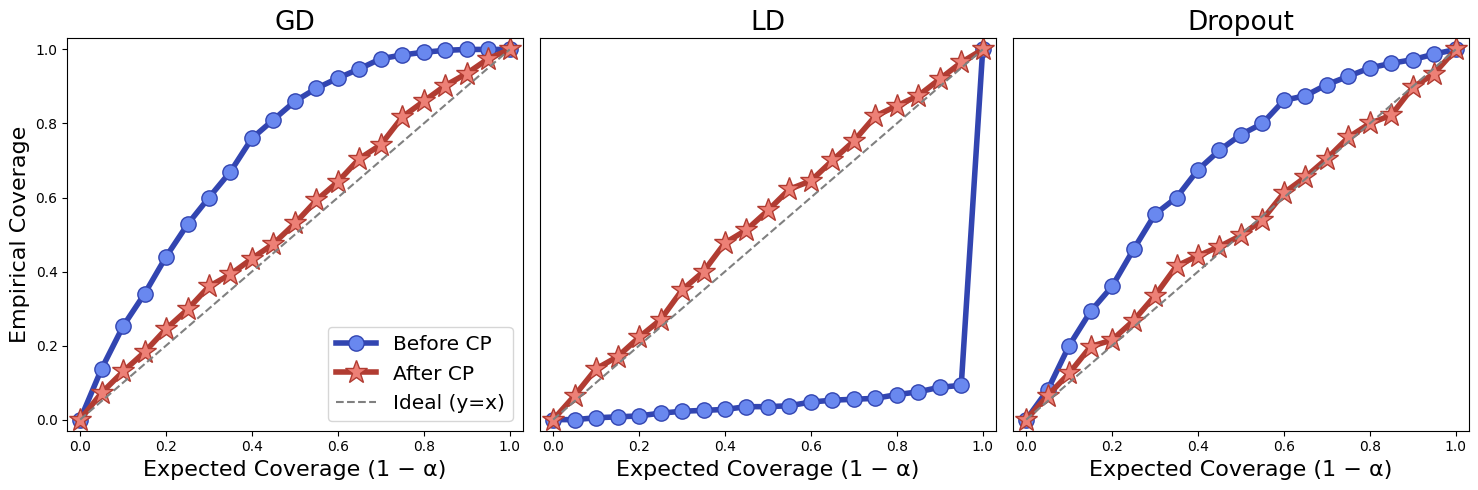

<Figure size 640x480 with 0 Axes>

In [ ]:
pairs = [
    ("GD",     dist_feat_pinn_df_uncal, dist_feat_pinndf_cal),
    ("LD",    dist_lat_pinn_df_uncal, dist_lat_pinn_df_cal),
    ("Dropout", dropout_pinn_df_uncal, dropout_pinn_df_cal),
]
fig, axs = plot_coverage_grid_2x2(pairs)



save_plot(
    plot_coverage_grid_2x2,
    save_dir="3D_Helmholtz", prefix="coverage_sets",
    loss=baseline_data_loss
)(pairs)

In [ ]:
def plot_coverage_grid_1x2(
    named_pairs,
    *,
    labels=("After CP", "After Local CP"),
    grid_figsize=(16, 7.5),
    suptitle=None,
    model_title_size=22,
    middle_ratio=0.55,              # width of legend column relative to each plot
):
    """
    named_pairs: list or dict of exactly 2 items like:
        [("Model A", df_uncal_A, df_cal_A), ("Model B", df_uncal_B, df_cal_B)]
        OR {"Model A": (df_uncal_A, df_cal_A), "Model B": (df_uncal_B, df_cal_B)}
    """
    import matplotlib.pyplot as plt
    import numpy as np

    def _prep(df):
        exp = 1.0 - df["alpha"].to_numpy()
        emp = df["coverage"].to_numpy()
        exp = np.concatenate(([0.0], exp, [1.0]))
        emp = np.concatenate(([0.0], emp, [1.0]))
        i = np.argsort(exp)
        return exp[i], emp[i]

    # normalize input
    items = list(named_pairs.items()) if isinstance(named_pairs, dict) else list(named_pairs)
    if len(items) != 2:
        raise ValueError("Provide exactly 2 (name, df_uncal, df_cal) pairs.")

    # 1x3 layout: [plot1 | legend | plot2]
    fig, axs = plt.subplots(
        1, 3,
        figsize=grid_figsize,
        sharey=True,
        gridspec_kw={"width_ratios": [1.0, middle_ratio, 1.0]}
    )

    legend_handles, legend_labels = None, None

    for ax_plot, (name, df_uncal, df_cal) in zip([axs[0], axs[2]], items):
        exp1, emp1 = _prep(df_uncal)
        exp2, emp2 = _prep(df_cal)

        ax_plot.plot(exp1, emp1, 'o-', color="#b13c32", markerfacecolor="#ed8076",
                     ms=14, lw=5, label=labels[0])
        ax_plot.plot(exp2, emp2, '*-', color="#3291b1", markerfacecolor="#69b5ef",
                     ms=20, lw=5, label=labels[1])
        ax_plot.plot([0, 1], [0, 1], '--', color='gray', label='Ideal (y=x)')

        # collect legend once
        if legend_handles is None:
            legend_handles, legend_labels = ax_plot.get_legend_handles_labels()

        # axis cosmetics
        ax_plot.set_xlabel("Expected Coverage (1 − α)", fontsize=18)
        ax_plot.autoscale(enable=True, tight=False)
        ax_plot.margins(x=0.02, y=0.02)
        ax_plot.set_title(name, fontsize=model_title_size)

    # Y label only on the left plot
    axs[0].set_ylabel("Empirical Coverage", fontsize=18)

    # Middle axis: legend only
    axs[1].axis("off")
    for spine in axs[1].spines.values():
        spine.set_visible(False)
    # Put the legend centered in the middle axis
    axs[1].legend(
        legend_handles, legend_labels,
        loc="center",
        frameon=False,
        ncol=3,
        fontsize=17
    )

    if suptitle:
        fig.suptitle(suptitle, fontsize=model_title_size + 2, y=0.98)

    fig.tight_layout(rect=[0, 0, 1, 0.96])

    return fig, axs


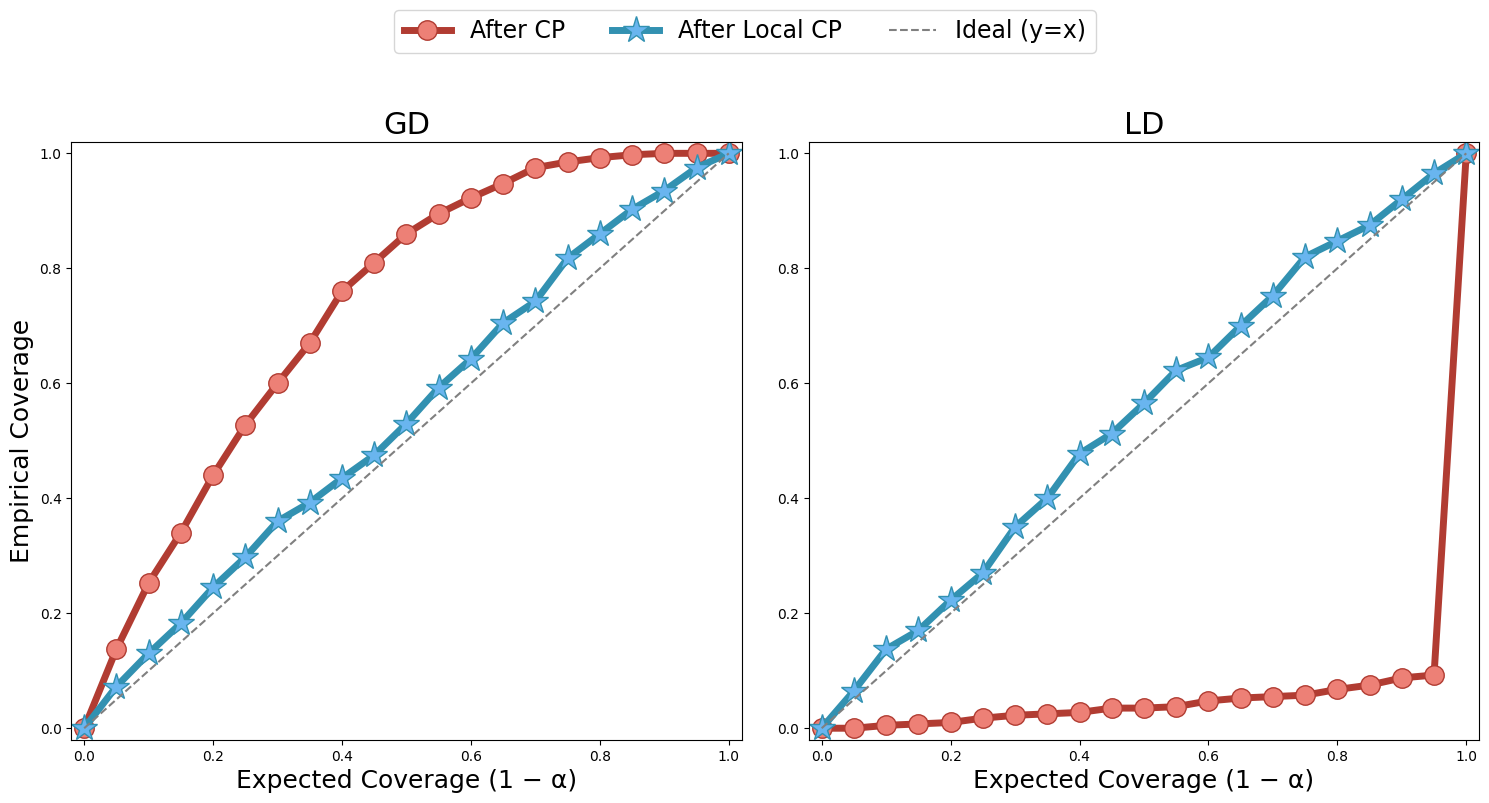

In [ ]:
pairs = [
    ("GD",     dist_feat_pinn_df_uncal, dist_feat_pinndf_cal),
    ("LD",    dist_lat_pinn_df_uncal, dist_lat_pinn_df_cal),
]
fig, axs = plot_coverage_grid_1x2(pairs)



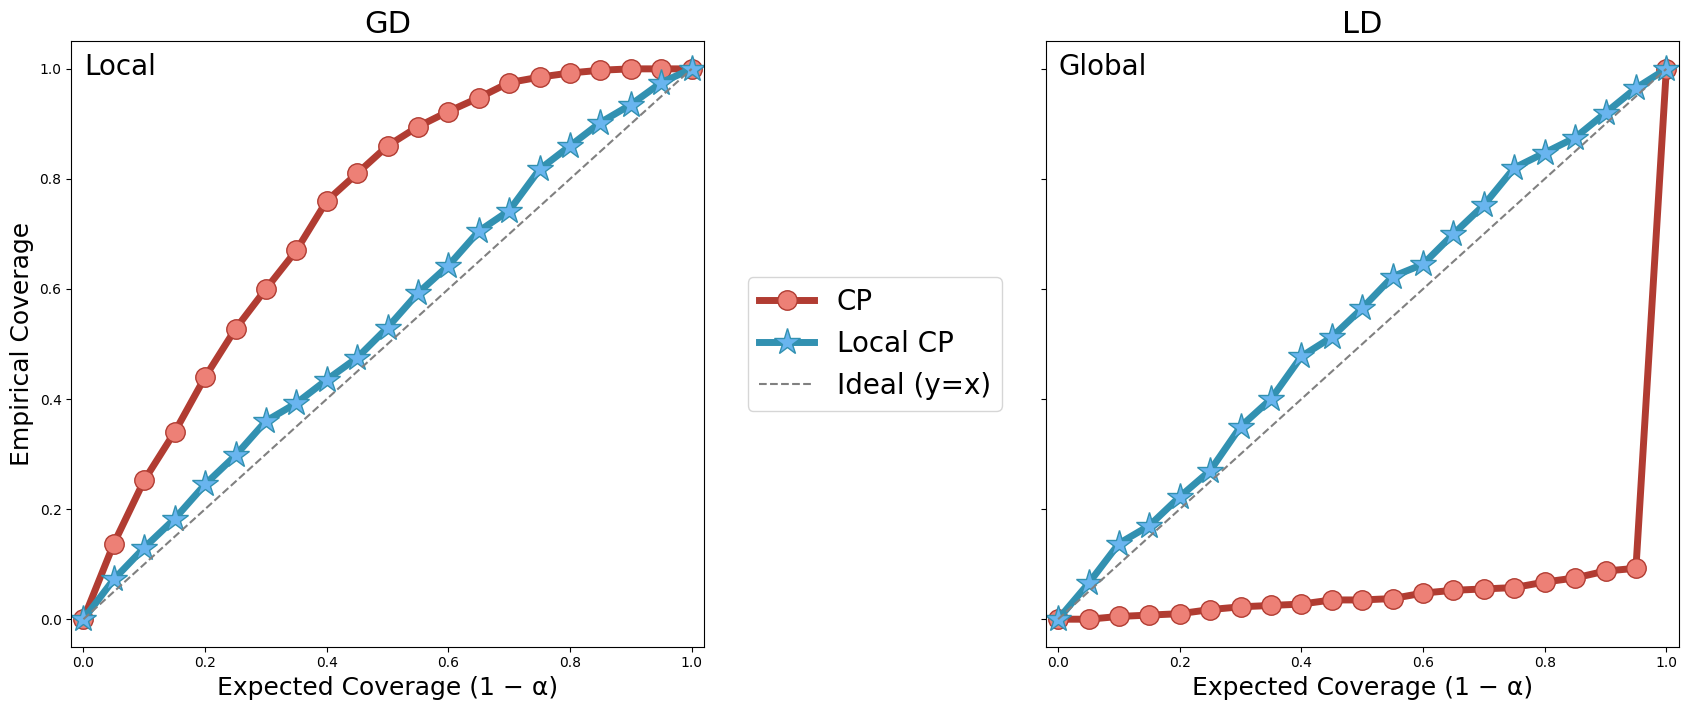

In [ ]:
pairs = [
    ("GD",     dist_feat_pinn_df_uncal, dist_feat_pinndf_cal),
    ("LD",    dist_lat_pinn_df_uncal, dist_lat_pinn_df_cal),
]
fig, axs = plot_coverage_grid_1x2_centered_legend(pairs)

